可以改的参数见每个大块的第一个代码块。

需要 amligraph2.0 的环境。


## 读入

下面为 model 的存储目录，可以改。

In [1]:
import os

MODELS_ROOT_PATH = "../models"
model_path = "yago3-10_2"
path_to_model = os.path.join(MODELS_ROOT_PATH, model_path)

定义 Dataset

In [2]:
# This file defines class Dataset to save train, valid, test

class Dataset:
    def __init__(self, path, name, separator="\t"):
        # {path} is the path of "models" folder
        # {name} is the folder name under the models directory
        # The default {separator} is "\t"

        self.path = path
        self.name = name
        self.home = os.path.join(path, self.name)

        if not os.path.isdir(self.home):
            raise Exception("Folder %s does not exist" % self.home)

        self.train_path = os.path.join(self.home, "train.txt")
        self.valid_path = os.path.join(self.home, "valid.txt")
        self.test_path = os.path.join(self.home, "test.txt")

        self.entities = set()
        self.relationships = set()

        # print("Reading train triples for %s..." % self.name)
        self.train_triples = self._read_triples(self.train_path, separator)
        # print("Reading validation triples for %s..." % self.name)
        self.valid_triples = self._read_triples(self.valid_path, separator)
        # print("Reading test triples for %s..." % self.name)
        self.test_triples = self._read_triples(self.test_path, separator)

    def _read_triples(self, triples_path, separator="\t"):
        triples = []
        with open(triples_path, "r") as triples_file:
            lines = triples_file.readlines()
            for line in lines:
                #line = html.unescape(line)
                head, relationship, tail = line.strip().split(separator)
                triples.append((head, relationship, tail))
                self.entities.add(head)
                self.entities.add(tail)
                self.relationships.add(relationship)
        return triples

数据读入

In [3]:
dataset = Dataset(MODELS_ROOT_PATH, model_path)

## 造

假设原先的 test 的每条边属于一个桶，测试数据将打乱桶之间的概率分布。

例，有 3 个桶，概率分布，为 0.2 0.2 0.6，记为 P

打乱可能为 0.3 0.3 0.4，记为 Q

然后会计算该分布和原分布的 KL 散度：KL(P||Q)

假设 KL 散度为 0~0.9，将线性分为若干个区间，每个区间的测试点数量一致。



In [4]:
num_box = 8 # 分桶数
output_dir = "./new_test_2" # 输出目录
max_KL = 0.9 # 生成的数据与原桶分布的 KL 散度在 0 ~ max_KL
num_range = 100 # KL 散度再划为 num_range 个区间。
tot_test = 1000 # 测试点总数量
test_num = 1000 # 每个测试点的边数
tag_file_name = "tag.txt" # 每条测试边所属的桶

这边推荐将分桶先输出到 tag_file_name，若你不想这么做，你可以直接修改下面的代码块。

In [5]:
t = [[] for _ in range(num_box)]
with open(tag_file_name, "r") as f:
    for i, line in enumerate(f.readlines()):
        cla = int(line.strip())
        t[cla].append(i)

In [6]:
import random

def get_num(s, test_num):
    n = len(s)
    num = []
    while(True):
        p = []
        sum = 0
        for i in range(n):
            p.append(random.random())
            sum += p[i] * s[i]
        if (sum > 0 and sum >= test_num):
            break
    prop = test_num / sum
    tot = 0
    for i in range(n):
        p[i] *= prop
        num.append(int(round(s[i] * p[i])))
        tot += num[i]
    while (tot < test_num):
        i = random.randint(0, n - 1)
        if (num[i] < s[i]):
            num[i] += 1
            tot += 1
    while (tot > test_num):
        i = random.randint(0, n - 1)
        if (num[i] > 0):
            num[i] -= 1
            tot -= 1
    return num

epsilon = 1e-9

import math

def get_KL(p, q):
    sum = 0
    for x, y in zip(p, q):
        x_ = x + epsilon
        y_ = y + epsilon
        sum += x_ * math.log(x_ / y_)
    return sum



不想生成数据请注释下面代码块。

In [7]:
from tqdm import tqdm

if (not os.path.exists(output_dir)):
    os.mkdir(output_dir)

with open(os.path.join(output_dir, "record.txt"), "w") as f:
    pass
hop = max_KL / num_range
w = 0


for idx in tqdm(range(tot_test), desc = "test_id"):
    if ((idx + 1) % (tot_test / num_range) == 0):
        w += hop
    while(True):
        num = get_num(
            [len(t[i]) for i in range(num_box)],
            test_num
        )
        KL = get_KL(
            [num[i] / test_num for i in range(num_box)],
            [len(t[i]) / len(dataset.test_triples) for i in range(num_box)]
        )
        if (KL >= w and KL < w + hop):
            break
    with open(os.path.join(output_dir,  "test_" + str(idx) + ".txt"), "w") as f:
        for i in range(num_box):
            for j in random.sample(t[i], num[i]):
                head, relation, tail = dataset.test_triples[j]
                f.write(head + '\t' + relation + '\t' + tail + '\n')
    with open(os.path.join(output_dir, "record.txt"), "a") as f:
        f.write(str(KL) + '\n')
                

test_id:   0%|          | 0/1000 [00:00<?, ?it/s]

test_id: 100%|██████████| 1000/1000 [00:40<00:00, 24.61it/s]


## 计算评分

默认用 MRR 指标，想改见代码注释。

op = 0 表示用一开始的 ranks.csv，op = 1 表示用模型重新评估（filter不一样）。

In [8]:
op = 0

In [9]:
from tqdm import tqdm
import numpy as np
from ampligraph.compat import evaluate_performance
from ampligraph.evaluation import mrr_score, hits_at_n_score, mr_score
from ampligraph.utils import restore_model
from ampligraph.datasets import load_from_csv

def load_dataset(PATH_TO_FOLDER):
    return {
        'train' : load_from_csv(PATH_TO_FOLDER, "train.txt"),
        'test' : load_from_csv(PATH_TO_FOLDER, "test.txt"),
        'valid' : load_from_csv(PATH_TO_FOLDER, "valid.txt")
    }

X = load_dataset(path_to_model)

In [10]:
if (op == 0):
    ranks = []
    with open(os.path.join(path_to_model, "ranks.csv"), "r") as f:
        for line in f.readlines():
            rank = line.strip()
            rank = rank.split(',')
            ranks.append([int(rank[0]), int(rank[1])])
    dic = {}
    for i, (head, relation, tail) in enumerate(X['test']):
        dic['+'.join([head, relation, tail])] = ranks[i]
else:
    model = restore_model(model_name_path=os.path.join(path_to_model, "models.pkl"))
    model.data_shape = 3



想不评估可注释下面的代码块。

In [11]:
store_name = "mrr.txt"

with open(os.path.join(output_dir, store_name), "w") as f:
    pass

for idx in tqdm(range(0, tot_test), desc = "test_id"):
    file_name = "test_" + str(idx) + ".txt"
    new_test = load_from_csv(output_dir, file_name)
    new_ranks = []
    if (op == 0):
        for (head, relation, tail) in new_test:
            new_ranks.append(dic['+'.join([head, relation, tail])])
    else:
        X['test'] = new_test
        filter = {'test' : np.concatenate((X['train'], X['valid'], X['test']))}
        new_ranks = evaluate_performance(X['test'],
                                    model=model,
                                    verbose = True,
                                    filter_triples=filter
                                    )
    with open(os.path.join(output_dir, store_name), "a") as f:
        # 将 mrr_score 改成 hits_at_n_score 即可。
        f.write(str(mrr_score(new_ranks)) + '\n')

test_id: 100%|██████████| 1000/1000 [00:08<00:00, 121.30it/s]


## 画图

第一幅图为每个测试点的评估指标与 KL 散度的散点分布图。

第二幅图为 KL 散度的每个线性区间的内部点的评估指标的标准差的折线图。

In [12]:
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np

l, r = [], []
s = 0
for i in range(num_range):
    l.append(s)
    s += hop
    r.append(s)

In [13]:
def draw(file_name):
    x = []
    y = []
    box = [[] for i in range(num_range)]
    with open(os.path.join(output_dir, "record.txt"), "r") as f:
        for line in f.readlines():
            x.append(float(line.strip()))

    with open(os.path.join(output_dir, file_name), "r") as f:
        for line in f.readlines():
            y.append(float(line.strip()))

    points = [(x[i], y[i]) for i in range(len(x))]

    # 计算凸包
    hull = ConvexHull(points)

    # 绘制散点图
    plt.scatter(*zip(*points), s = 5)

    # 绘制凸包

    for simplex in hull.simplices:
        plt.plot([points[simplex[0]][0], points[simplex[1]][0]], [points[simplex[0]][1], points[simplex[1]][1]], 'r-')

    # 添加标签和标题
    plt.xlabel('KL')
    plt.ylabel('MRR')
    plt.title("pic")

    # 显示图像
    plt.show()

    for i in range(len(x)):
        for j in range(num_range):
            if (x[i] >= l[j] and x[i] < r[j]):
                box[j].append(y[i])
                break
    
    x_ = []
    y_ = []
    for i in range(num_range):
        std = np.std(np.array(box[i]))
        x_.append((l[i] + r[i]) / 2)
        y_.append(std)
    x_ = np.array(x_)
    y_ = np.array(y_)

    # 使用最小二乘法计算拟合直线的参数
    A = np.vstack([x_, np.ones(len(x_))]).T
    m, c = np.linalg.lstsq(A, y_, rcond=None)[0]

    # 绘制原始数据和拟合直线
    plt.plot(x_, y_, label='original')
    plt.plot(x_, m*x_ + c, 'r', label='linear')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show() 

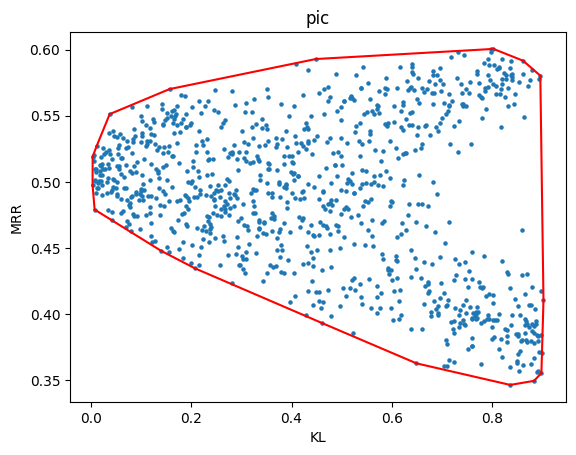

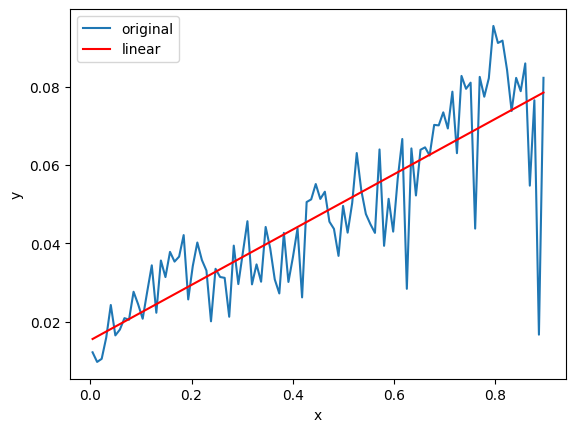

In [14]:
draw(store_name)